In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from importlib import reload
import os, sys, re, glob, time, pickle, IPython, logging
import scipy.ndimage as ndi
from itertools import islice
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchmore import layers, flex
import torchtrainers as tt
from torch.utils.data import DataLoader
from webdataset import WebDataset
import ocrhelpers as helpers
from ocrhelpers import *
import ocrmodels as models
RUN("date"); RUN("hostname"); RUN("whoami"); RUN("nvidia-smi -L")

charset = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

def encode_str(s): 
    return [charset.find(c)+1 for c in s]

def decode_str(l): 
    return "".join([charset[k-1] for k in l])

transforms = [
    lambda x: (torch.tensor(x).float()/255.0).unsqueeze(0),
    lambda s: torch.tensor(encode_str(s)).long()
]
training = WebDataset("data/words-simple-training.tar", decoder="l8", 
                      extensions="jpg;jpeg;ppm;png txt", transforms=transforms)
testing = WebDataset("data/words-simple-test.tar", decoder="l8", 
                     extensions="jpg;jpeg;ppm;png txt", transforms=transforms)
training_dl = DataLoader(training, batch_size=5, collate_fn=helpers.collate4ocr)
testing_dl = DataLoader(testing, batch_size=20, collate_fn=helpers.collate4ocr)
next(iter(training_dl))[0].size()

date : Mon Sep 30 10:29:46 PDT 2019
hostname : baldr
whoami : tmb
nvidia-smi -L : GPU 0: TITAN V (UUID: GPU-d4e8727f-83eb-5631-119d-1e89b6f6ce55)
GPU 1: TITAN V (UUID: GPU-11093101-e490-ab44-264e-65fbcfa3d823)


torch.Size([5, 1, 112, 464])

In [3]:
!awk '/ocr_resnet/' RS="\n\n" ocrmodels.py


def make_ocr_resnet(noutput=noutput):
    model = nn.Sequential(
        layers.Input("BDHW", range=(0, 1), sizes=[None, 1, None, None]),
        *conv2mp(64, 3, 2),
        *resnet_blocks(5, 64),
        *conv2mp(128, 3, (2, 1)),
        *resnet_blocks(5, 128),
        *conv2mp(192, 3, 2),
        *resnet_blocks(5, 192),
        *conv2mp(256, 3, (2, 1)),
        *resnet_blocks(5, 256),
        *conv2d(512, 3),
        *project_and_conv1d(512, noutput)
    )
    flex.shape_inference(model, (1, 1, 128, 512))
    return model


In [4]:
model = models.make("ocr_resnet")

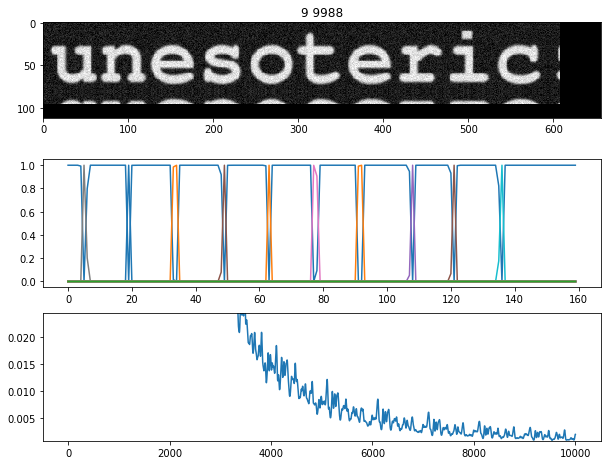

In [5]:
trainer = helpers.LineTrainer(model)
trainer.train(training_dl, 10, every=10)

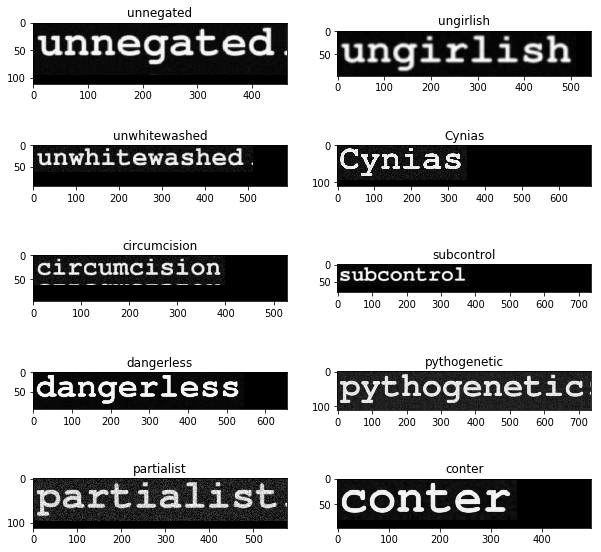

In [6]:
figsize(10, 10)
for i, batch in enumerate(islice(training_dl, 0, 10)):
    subplot(5, 2, i+1)
    result = trainer.predict_batch(*batch[:2], threshold=0.8)
    imshow(batch[0][0,0].detach().numpy())
    title(decode_str(result[0]))

In [7]:
trainer.errors(testing_dl)

(11, 95969)